## Check global mean top-of-atmosphere net energy flux
### Calculate effective planetary temperature

In [1]:
import warnings
from pathlib import Path

import iris
import iris.pandas
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from aeolus.calc.diag import toa_eff_temp
from aeolus.calc.stats import spatial_mean
from aeolus.coord import get_cube_rel_days, interp_to_cube_time
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator

In [3]:
from util_commons import PLANETS, SUITES
from util_mypaths import path_to_data_umserve, path_to_results
from util_plot_func import use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
use_paper_style()

In [5]:
# Parameters
metallicity = "solar"

In [6]:
# Process data
vrbls = {}
for planet in PLANETS.keys():
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        # Load data
        fpath = SUITES[planet][exp][metallicity]["dir_for_merged"]
        fname = f"{SUITES[planet][exp][metallicity]['suite']}.nc"
        toa_isr = iris.load_cube(str(fpath / fname), um.toa_isr)  # toa_incoming_shortwave_flux
        _toa_olr = iris.load_cube(str(fpath / fname), um.toa_olr)  # toa_outgoing_longwave_flux
        toa_osr = iris.load_cube(str(fpath / fname), um.toa_osr)  # toa_outgoing_shortwave_flux
        # Remove forecast_period coordinate
        toa_isr.remove_coord("forecast_period")
        _toa_olr.remove_coord("forecast_period")
        toa_osr.remove_coord("forecast_period")
        # Interpolate _toa_olr to toa_isr's time coordinate
        toa_olr = interp_to_cube_time(_toa_olr, toa_isr, model=um)
        # Calculate global mean TOA incoming, outgoing and net energy fluxes
        toa_isr_mean = spatial_mean(toa_isr, model=um)
        toa_olr_mean = spatial_mean(toa_olr, model=um)
        toa_net_mean = spatial_mean(toa_isr - toa_olr - toa_osr, model=um)
        toa_isr_mean.rename("global_mean_toa_incoming_energy_flux")
        toa_net_mean.rename("global_mean_toa_net_energy_flux")
        # Find number of simulation days since the first model output on day 10
        time_in_rel_days = get_cube_rel_days(toa_isr, model=um) + 10
        # Assemble data
        vrbls[planet][exp] = {
            "time_in_rel_days": time_in_rel_days,
            "toa_isr_mean": toa_isr_mean,
            "toa_olr_mean": toa_olr_mean,
            "toa_net_mean": toa_net_mean,
        }

In [7]:
# Print final values the global mean TOA incoming energy flux
for planet in PLANETS.keys():
    for exp in ["equilibrium", "kinetics"]:
        print(planet, exp, vrbls[planet][exp]["toa_isr_mean"][-1].data / 1e3)  # [kW m-2]

hatp11b equilibrium 26.97456350260436
hatp11b kinetics 26.97456350260436
hd189733b equilibrium 115.03680007923188
hd189733b kinetics 115.03680007923188
hd209458b equilibrium 259.0452749574389
hd209458b kinetics 259.0452749574389
wasp17b equilibrium 540.1247698087957
wasp17b kinetics 540.1247698087957


In [8]:
# Print final values for the global mean TOA net energy flux
for planet in PLANETS.keys():
    for exp in ["equilibrium", "kinetics"]:
        print(planet, exp, vrbls[planet][exp]["toa_net_mean"][-1].data / 1e3)  # [kW m-2]

hatp11b equilibrium 0.575285579793861
hatp11b kinetics 0.7167362856901693
hd189733b equilibrium 4.145782316189743
hd189733b kinetics 5.206517656136443
hd209458b equilibrium 7.885853743246292
hd209458b kinetics 8.049348531458742
wasp17b equilibrium 22.594909502336325
wasp17b kinetics 22.595997691135434


In [9]:
# Print final values for the relationship between global mean incoming and net energy fluxes
# net as a % of incoming
for planet in PLANETS.keys():
    for exp in ["equilibrium", "kinetics"]:
        print(
            planet,
            exp,
            vrbls[planet][exp]["toa_net_mean"][-1].data
            * 100
            / vrbls[planet][exp]["toa_isr_mean"][-1].data,
        )  # [%]

hatp11b equilibrium 2.13269652996727
hatp11b kinetics 2.6570820529532178
hd189733b equilibrium 3.603874858596836
hd189733b kinetics 4.525958347720417
hd209458b equilibrium 3.044199028352066
hd209458b kinetics 3.1073133963865
wasp17b equilibrium 4.183275932769188
wasp17b kinetics 4.183477402662801


In [10]:
# Calculate effective planetary temperature
for planet in PLANETS.keys():
    toa_temp_eff_by_planet = []
    for exp in ["equilibrium", "kinetics"]:
        cl = iris.cube.CubeList()
        cl.append(vrbls[planet][exp]["toa_olr_mean"][-1])
        toa_temp_eff_by_planet.append(toa_eff_temp(cl).data)
    #         print(planet, exp, toa_eff_temp(cl).data)  # K
    print(planet, round(np.array(toa_temp_eff_by_planet).mean()))  # K

hatp11b 813
hd189733b 1162
hd209458b 1391
wasp17b 1622


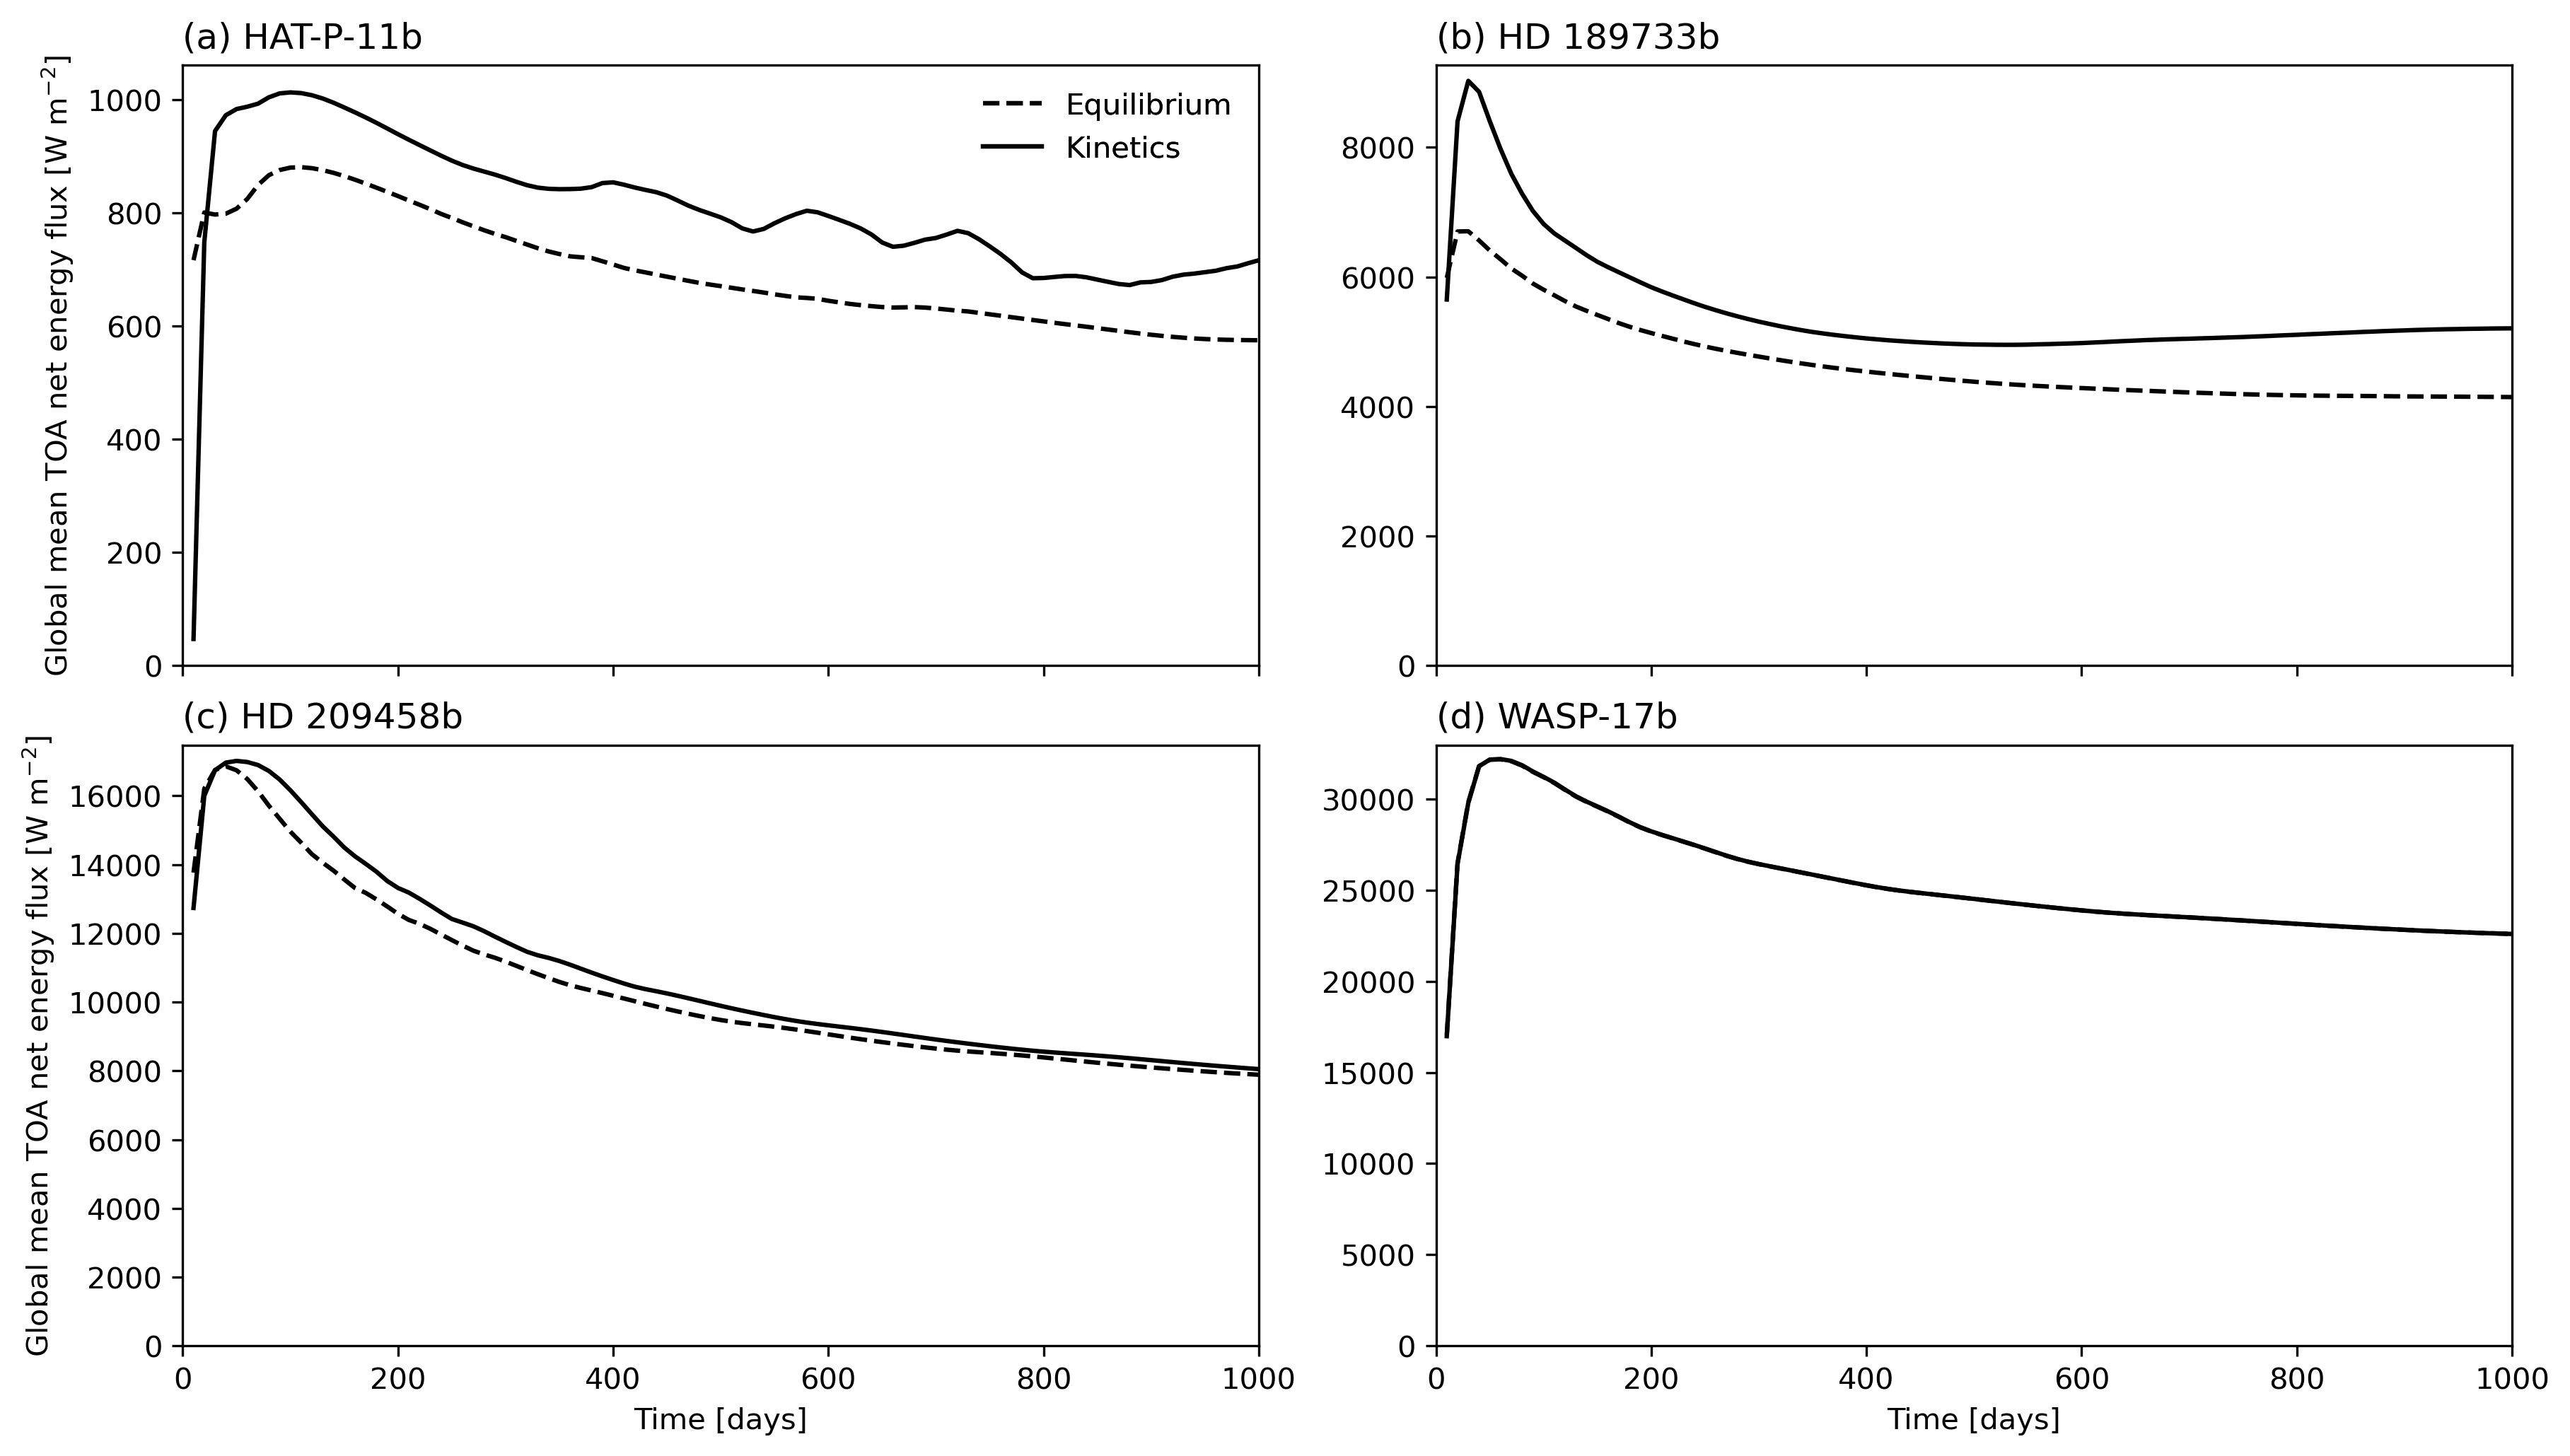

In [11]:
# Plot TOA net energy flux vs time
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 6.75), sharex=True, constrained_layout=True)
iletters = subplot_label_generator()
for planet, iax in zip(PLANETS.keys(), ax.flatten()):
    iax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    for exp, linestyle in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        iax.plot(
            vrbls[planet][exp]["time_in_rel_days"],
            vrbls[planet][exp]["toa_net_mean"].data,
            linestyle=linestyle,
            color="k",
        )
    if iax.get_subplotspec().is_first_col():
        iax.set_ylabel("Global mean TOA net energy flux [W $m^{-2}$]")
        if iax.get_subplotspec().is_first_row():
            add_custom_legend(
                iax,
                {
                    "equilibrium".capitalize(): {"linestyle": "dashed", "color": "k"},
                    "kinetics".capitalize(): {"linestyle": "solid", "color": "k"},
                },
                frameon=False,
                loc="upper right",
            )
for iax in ax.flatten():
    iax.set_xlim(0, 1000)
    iax.set_ylim(bottom=0)
    if iax.get_subplotspec().is_last_row():
        iax.set_xlabel("Time [days]")
figname = "steady_state_ts_toa_net.png"
fig.savefig(path_to_results / "steady_state" / figname)

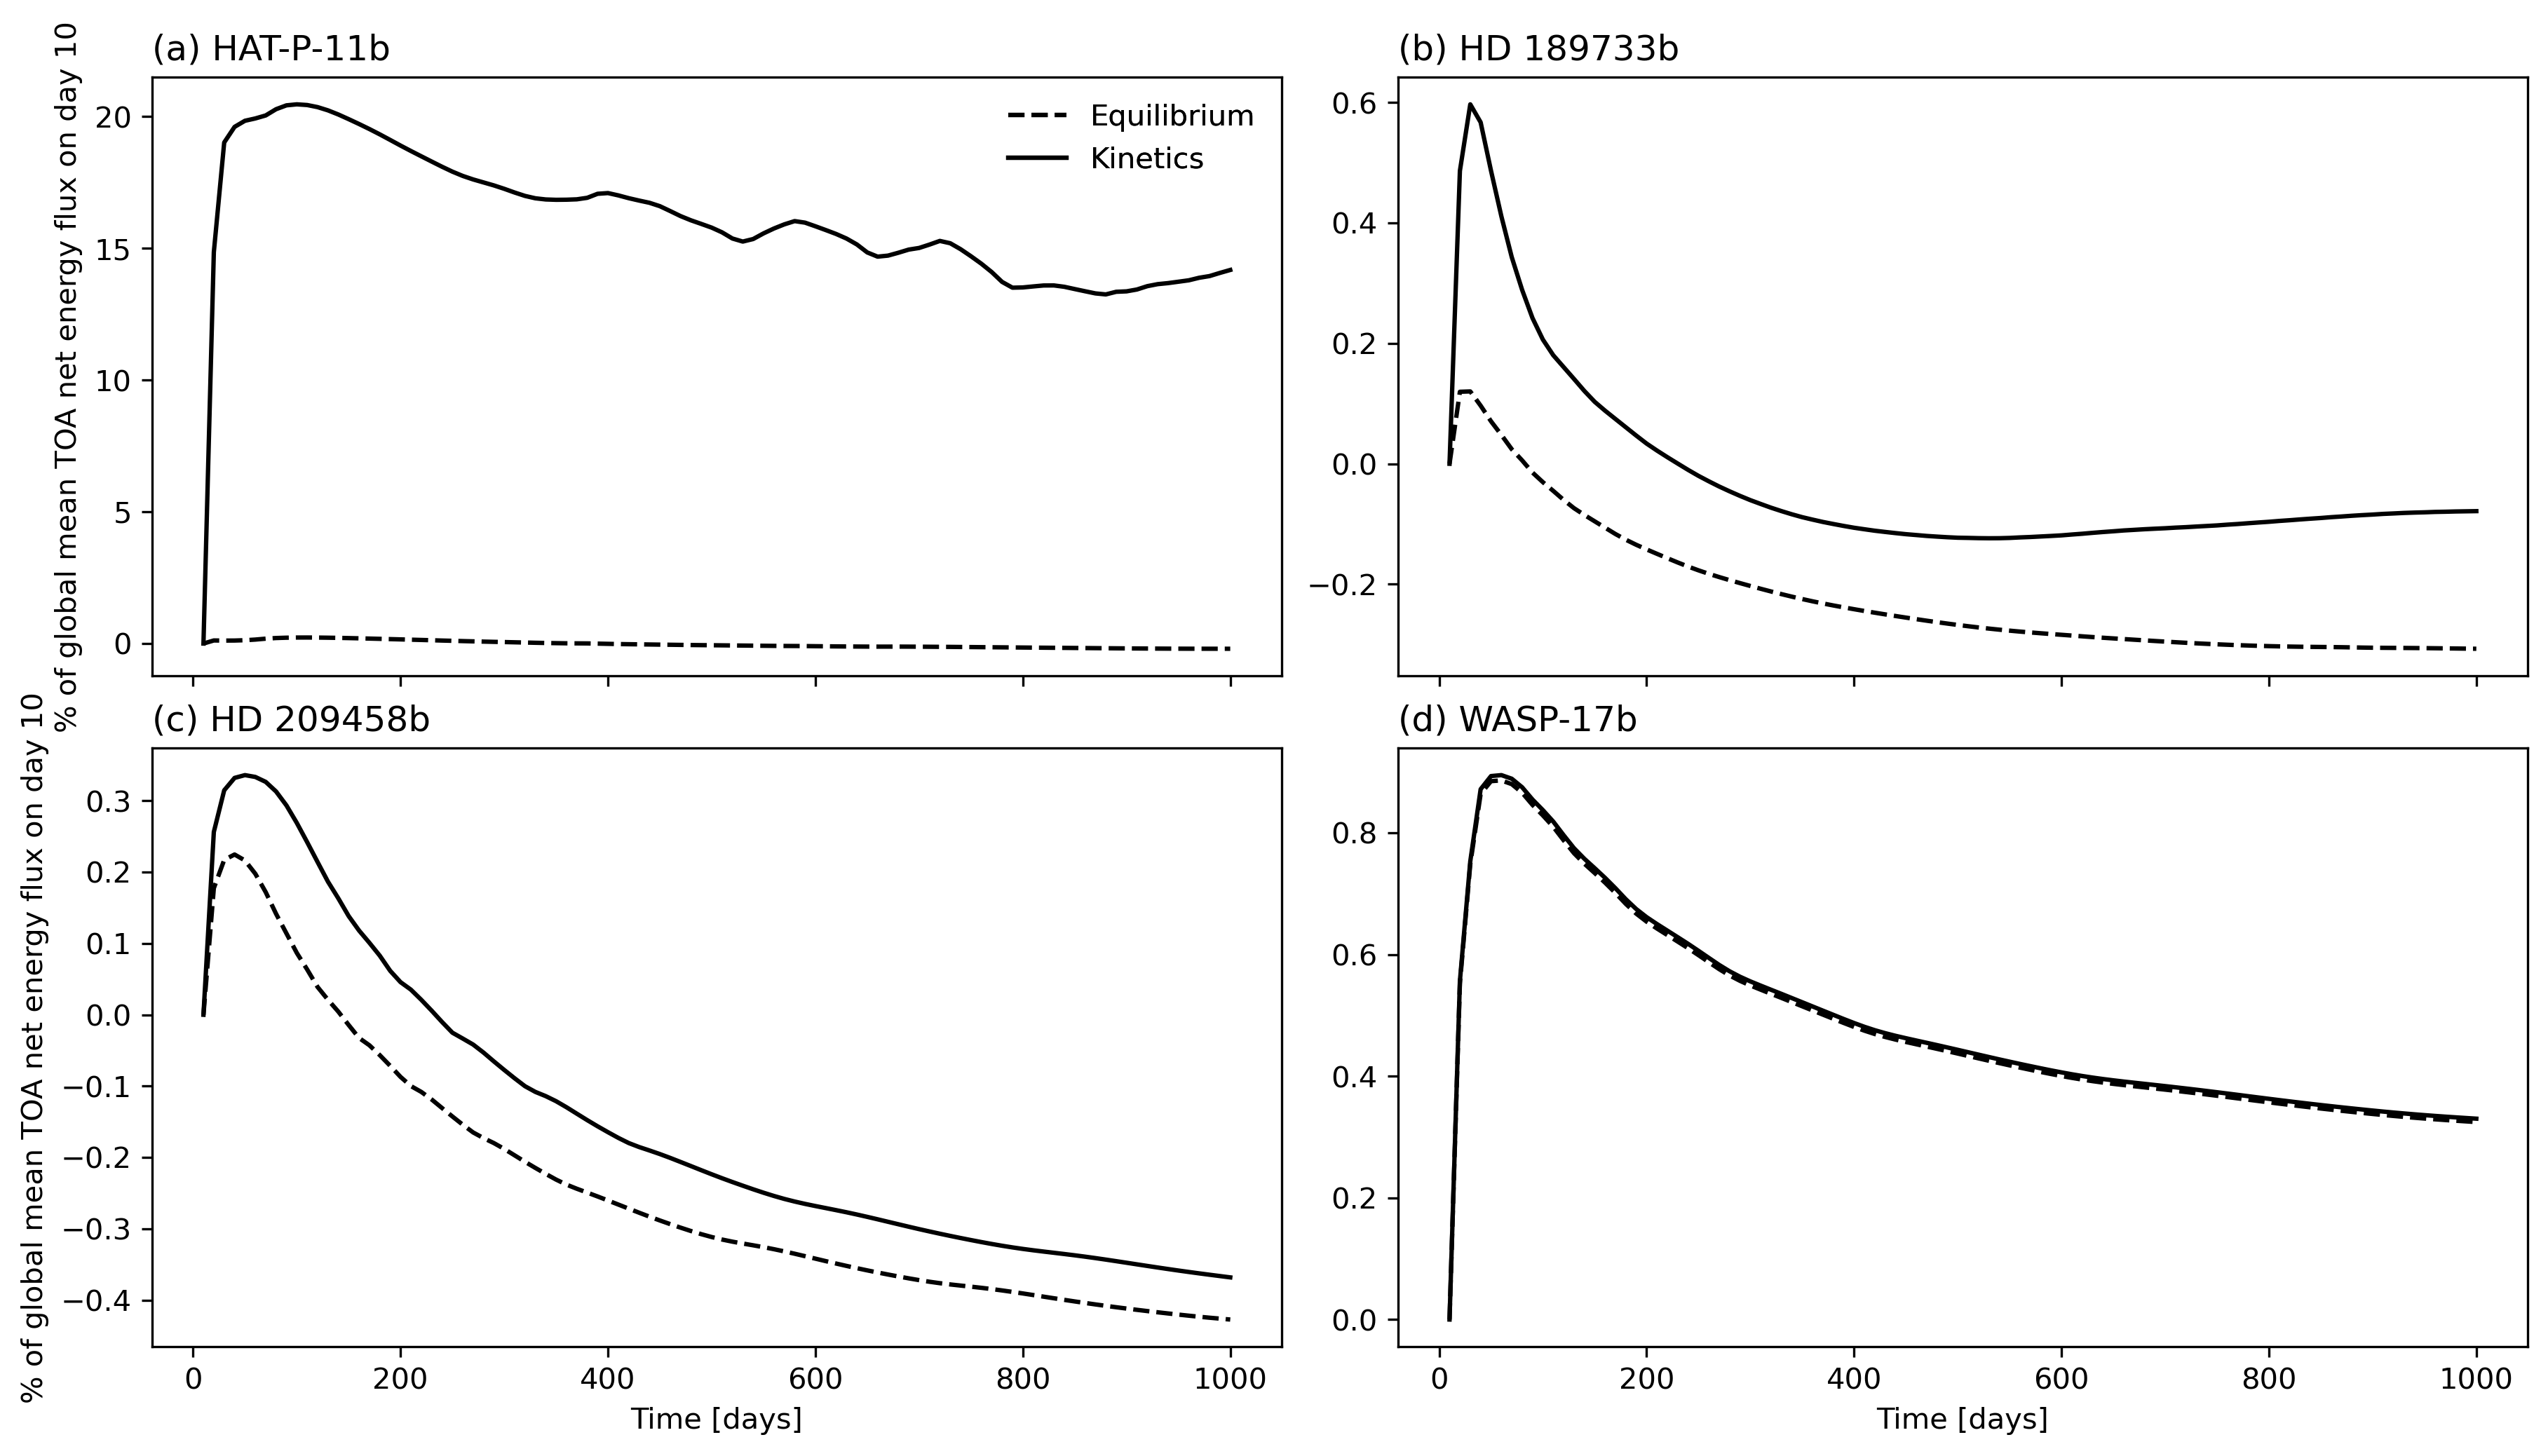

In [12]:
# Plot % change in TOA net energy fluxes starting on day 10 vs time
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 6.75), sharex=True, constrained_layout=True)
iletters = subplot_label_generator()
for planet, iax in zip(PLANETS.keys(), ax.flatten()):
    iax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    for exp, linestyle in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        iax.plot(
            vrbls[planet][exp]["time_in_rel_days"],
            iris.pandas.as_series(vrbls[planet][exp]["toa_net_mean"], copy=True)
            .pct_change()
            .fillna(0)
            .add(1)
            .cumprod()
            .sub(1),
            linestyle=linestyle,
            color="k",
        )
    if iax.get_subplotspec().is_first_col():
        iax.set_ylabel("% of global mean TOA net energy flux on day 10")
        if iax.get_subplotspec().is_first_row():
            add_custom_legend(
                iax,
                {
                    "equilibrium".capitalize(): {"linestyle": "dashed", "color": "k"},
                    "kinetics".capitalize(): {"linestyle": "solid", "color": "k"},
                },
                frameon=False,
                loc="upper right",
            )
for iax in ax.flatten():
    #     iax.set_xlim(0, 1000)
    #     iax.set_ylim(bottom=0)
    if iax.get_subplotspec().is_last_row():
        iax.set_xlabel("Time [days]")
figname = "steady_state_ts_toa_net_pct_of_initial.png"
fig.savefig(path_to_results / "steady_state" / figname)

In [13]:
iris.pandas.as_series(vrbls["hatp11b"]["kinetics"]["toa_net_mean"], copy=True).pct_change().fillna(
    0
).add(1).cumprod().sub(1)[-20:]

2004-08-11 09:00:00    13.556634
2004-08-21 09:00:00    13.592473
2004-08-31 09:00:00    13.594373
2004-09-10 09:00:00    13.542779
2004-09-20 09:00:00    13.457059
2004-09-30 09:00:00    13.373494
2004-10-10 09:00:00    13.291863
2004-10-20 09:00:00    13.253551
2004-10-30 09:00:00    13.352964
2004-11-09 09:00:00    13.369941
2004-11-19 09:00:00    13.439935
2004-11-29 09:00:00    13.566415
2004-12-09 09:00:00    13.643194
2004-12-19 09:00:00    13.682399
2004-12-29 09:00:00    13.735350
2005-01-08 09:00:00    13.788981
2005-01-18 09:00:00    13.885207
2005-01-28 09:00:00    13.949423
2005-02-07 09:00:00    14.069320
2005-02-17 09:00:00    14.181753
dtype: float32

In [14]:
(
    iris.pandas.as_series(vrbls["hatp11b"]["kinetics"]["toa_net_mean"], copy=True)
    .pct_change()
    .fillna(0)
    .add(1)
    .cumprod()
    .sub(1)[-20:]
    .max()
    - iris.pandas.as_series(vrbls["hatp11b"]["kinetics"]["toa_net_mean"], copy=True)
    .pct_change()
    .fillna(0)
    .add(1)
    .cumprod()
    .sub(1)[-20:]
    .min()
)

0.9282026